In [1]:
#| default_exp bb_utils

In [2]:
#| export
import numpy as np
import pandas as pd
from PIL.Image import Image
from typing import Tuple

In [3]:
#| export
#| hide
randint = np.random.randint

class BB:
    """A Bounding Box defined by the top-left and bottom-right coordinates"""
    def __init__(self, *bb):
        # assert len(bb) == 4, 'expecting a list/tuple of 4 values respectively for (x,y,X,Y)'
        if len(bb) == 4:
            x, y, X, Y = bb
        elif len(bb) == 1:
            ((x, y, X, Y),) = bb
        rel = True if max(x, y, X, Y) < 1 else False
        if not rel:
            x, y, X, Y = map(lambda i: int(round(i)), (x, y, X, Y))
        self.bb = x, y, X, Y
        self.x, self.y, self.X, self.Y = x, y, X, Y
        self.xc, self.yc = (self.x + self.X) / 2, (self.y + self.Y) / 2
        self.c = (self.xc, self.yc)
        self.h = Y - y
        self.w = X - x
        self.area = self.h * self.w
        self.shape = (self.h, self.w)

    def __getitem__(self, i):
        return self.bb[i]

    def __repr__(self):
        return self.bb.__repr__()

    def __len__(self):
        return 4

    def __eq__(self, other):
        return (
            self.x == other.x
            and self.y == other.y
            and self.X == other.X
            and self.Y == other.Y
        )

    def __hash__(self):
        return hash(tuple(self))

    def __add__(self, origin):
        a, b = origin[:2]
        x, y, X, Y = self
        return BB(x + a, y + b, X + a, Y + b)

    def remap(self, og_dim: Tuple[int, int], new_dim: Tuple[int, int]):
        """
        og_dim = (Height, Width)
        new_dim = (Height, Width)
        """
        h, w = og_dim
        H, W = new_dim
        sf_x = H / h
        sf_y = W / w
        return BB(
            round(sf_x * self.x),
            round(sf_y * self.y),
            round(sf_x * self.X),
            round(sf_y * self.Y),
        )

    def relative(self, dim: Tuple[int, int]):
        h, w = dim
        return BB(self.x / w, self.y / h, self.X / w, self.Y / h)

    def absolute(self, dim: Tuple[int, int]):
        h, w = dim
        return BB(self.x * w, self.y * h, self.X * w, self.Y * h)

    def local_to(self, _bb):
        x, y, X, Y = self
        a, b, A, B = _bb
        return BB(x - a, y - b, X - a, Y - b)

    def jitter(self, noise, preserve_shape=True):
        if isinstance(noise, (int, float)):
            return BB([i + (noise - randint(2 * noise)) for i in self])
        elif isinstance(noise, (list, tuple)):
            if len(noise) == 2:
                dx, dy = noise
                dx, dy, dX, dY = dx / 2, dy / 2, dx / 2, dy / 2
            elif len(noise) == 4:
                dx, dy, dX, dY = noise
            if 0 < dx < 1:
                dx = int(self.w * dx)
            if 0 < dX < 1:
                dX = int(self.w * dX)
            if 0 < dy < 1:
                dy = int(self.h * dy)
            if 0 < dY < 1:
                dY = int(self.w * dY)
            dx = dx - 2 * randint(dx + 1)
            dy = dy - 2 * randint(dy + 1)
            if preserve_shape:
                dX = dx
                dY = dy
            else:
                dX = dX - 2 * randint(dX + 1)
                dY = dy - 2 * randint(dY + 1)
            dbb = BB(dx, dy, dX, dY)
            return BB([max(0, i + j) for i, j in zip(self, dbb)])

    def shrink_inplace(self):
        "return a new thing, shrunk"

    def add_padding(self, *pad):
        if len(pad) == 4:
            _x, _y, _X, _Y = pad
        else:
            (pad,) = pad
            _x, _y, _X, _Y = pad, pad, pad, pad
        x, y, X, Y = self.bb
        return max(0, x - _x), max(0, y - _y), X + _x, Y + _y

    def l2(self, other, xyfactor=(1, 1)):
        _x_, _y_ = xyfactor
        other = BB(other)
        xc, yc = self.xc, self.yc
        ac, bc = other.xc, other.yc
        return np.sqrt(_x_ * (xc - ac) ** 2 + _y_ * (yc - bc) ** 2)

    def distances(self, other_bbs, threshold=None, direction=None):
        other_bbs = bbfy(other_bbs)
        if direction:
            assert direction in "x,y,left,right,top,down".split(",")
            if direction == "x":
                output = [
                    (ix, bb, self.l2(bb, xyfactor=(1, 1000))) for (ix, bb) in other_bbs
                ]
                return pd.DataFrame(output, columns="ix,bb,dist".split(","))
            raise NotImplementedError("")
        return sorted(other_bbs, key=lambda obj: self.l2(obj[1]))


Create a box by mentioning the top-left (x, y) and bottom-right (X, Y) coordinates  
Say `x, y, X, Y` are `10, 20, 40, 50` respectively

In [4]:
bb = BB([10,20,40,50])

You get the following attributes for free

In [5]:
#| echo: false
print(f'''
bb.x={bb.x:<15} (top left - x)
bb.y={bb.y:<15} (top left - y)
bb.X={bb.X:<15} (bottom right - x)
bb.Y={bb.Y:<15} (bottom right - y)
bb.w={bb.w:<15} (width)
bb.h={bb.h:<15} (height)
bb.xc={bb.xc:<14} (center x)
bb.yc={bb.yc:<14} (center y)
bb.c={bb.c}    (center)
bb.area={bb.area:<12} (area)
bb.shape={bb.shape}    (height, width)
''')


bb.x=10              (top left - x)
bb.y=20              (top left - y)
bb.X=40              (bottom right - x)
bb.Y=50              (bottom right - y)
bb.w=30              (width)
bb.h=30              (height)
bb.xc=25.0           (center x)
bb.yc=35.0           (center y)
bb.c=(25.0, 35.0)    (center)
bb.area=900          (area)
bb.shape=(30, 30)    (height, width)



In [6]:
#| export
#| hide
def df2bbs(df):
    if "bb" in df.columns:
        try:
            return bbfy(df["bb"].values.tolist())
        except:
            return bbfy(df["bb"].map(lambda x: eval(x)).values.tolist())
    return [BB(bb) for bb in df[list("xyXY")].values.tolist()]


def bbs2df(bbs):
    bbs = [list(bb) for bb in bbs]
    return pd.DataFrame(bbs, columns=["x", "y", "X", "Y"])


def bbfy(bbs):
    return [BB(bb) for bb in bbs]


def jitter(bbs, noise):
    return [BB(bb).jitter(noise) for bb in bbs]



def compute_eps(eps):
    if isinstance(eps, tuple):
        if len(eps) == 4:
            epsx, epsy, epsX, epsY = eps
        else:
            epsx, epsy = eps
            epsx, epsy, epsX, epsY = epsx / 2, epsy / 2, epsx / 2, epsy / 2
    else:
        epsx, epsy, epsX, epsY = eps / 2, eps / 2, eps / 2, eps / 2
    return epsx, epsy, epsX, epsY


def enlarge_bbs(bbs, eps=0.2):
    "enlarge all `bbs` by `eps` fraction (i.e., eps*100 percent)"
    bbs = bbfy(bbs)
    epsx, epsy, epsX, epsY = compute_eps(eps)
    bbs = bbfy(bbs)
    shs = [(bb.h, bb.w) for bb in bbs]
    return [
        BB(x - (w * epsx), y - (h * epsy), X + (w * epsX), Y + (h * epsY))
        for (x, y, X, Y), (h, w) in zip(bbs, shs)
    ]


def shrink_bbs(bbs, eps=0.2):
    "shrink all `bbs` by `eps` fraction (i.e., eps*100 percent)"
    bbs = bbfy(bbs)
    epsx, epsy, epsX, epsY = compute_eps(eps)
    bbs = bbfy(bbs)
    shs = [(bb.h, bb.w) for bb in bbs]
    return [
        BB(x + (w * epsx), y + (h * epsy), X - (w * epsX), Y - (h * epsY))
        for (x, y, X, Y), (h, w) in zip(bbs, shs)
    ]

In [7]:
#| export
#| hide
def iou(bboxes1, bboxes2):
    bboxes1 = np.array(bboxes1)
    bboxes2 = np.array(bboxes2)
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [8]:
#| export
#| hide
def split_bb_to_xyXY(df):
    "convert bb column to separate x,y,X,Y columns"
    df = df.copy()
    assert isinstance(df, pd.DataFrame)
    if all([item in df.columns for item in 'xyXY']):
        return df
    assert 'bb' in df.columns, 'Expecting the df\'s bounding boxes to be in `bb` column'
    try:
        df['bb'] = df['bb'].map(eval)
    except:
        pass
    df['x'] = df['bb'].map(lambda x: x[0])
    df['y'] = df['bb'].map(lambda x: x[1])
    df['X'] = df['bb'].map(lambda x: x[2])
    df['Y'] = df['bb'].map(lambda x: x[3])
    df.drop(['bb'], axis=1, inplace=True)
    return df

def combine_xyXY_to_bb(df):
    "combine `x,y,X,Y` to `bb` column"
    df = df.copy()
    assert all([item in df.columns for item in 'xyXY']), "All the columns `x`, `y`, `X`, `Y` should be in df"
    df['bb'] = df[[*'xyXY']].values.tolist()
    df.drop([*'xyXY'], inplace=True, axis=1)
    return df
    

def to_relative(df, height, width):
    df = df.copy()
    if 'x' not in df.columns and 'bb' in df.columns:
        _recombine = True
        df = split_bb_to_xyXY(df)
    else:
        _recombine = False
    df["x"] = df["x"] / width
    df["y"] = df["y"] / height
    df["X"] = df["X"] / width
    df["Y"] = df["Y"] / height
    if _recombine:
        df = combine_xyXY_to_bb(df)
    return df

def to_absolute(df, height, width):
    df = df.copy()
    if 'x' not in df.columns and 'bb' in df.columns:
        _recombine = True
        df = split_bb_to_xyXY(df)
    else:
        _recombine = False
    df["x"] = (df["x"] * width).astype(np.uint16)
    df["y"] = (df["y"] * height).astype(np.uint16)
    df["X"] = (df["X"] * width).astype(np.uint16)
    df["Y"] = (df["Y"] * height).astype(np.uint16)
    if _recombine:
        df = combine_xyXY_to_bb(df)
    return df

In [9]:
from torch_snippets import *
im = read('/data1/yeshwanth/torch_snippets/assets/Preamble.png')
df = pd.read_csv('/data1/yeshwanth/torch_snippets/assets/Preamble.csv')
df = to_relative(df, *im.shape[:2])

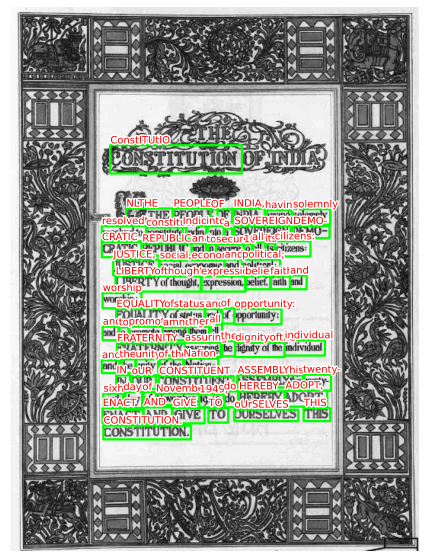

In [10]:
show(im, df=df, sz=10)

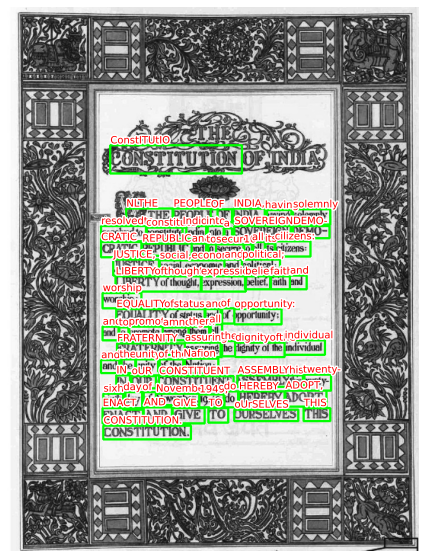

In [11]:
show(im, df=to_absolute(df, *im.shape[:2]), sz=10)

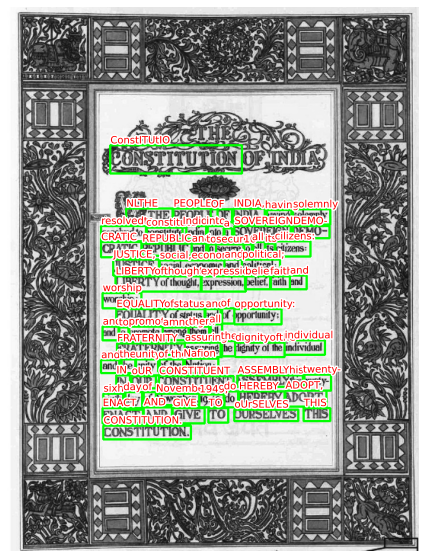

In [12]:
_df = to_absolute(df, *im.shape[:2])
show(im, df=to_relative(_df, *im.shape[:2]), sz=10)

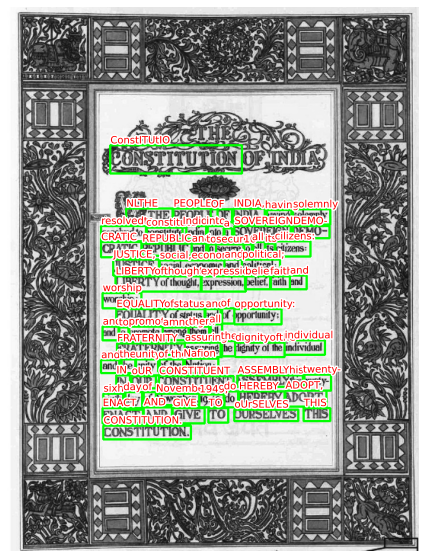

In [13]:
_df = combine_xyXY_to_bb(_df)
show(im, df=to_relative(_df, *im.shape[:2]), sz=10)

In [14]:
to_relative(_df, *im.shape[:2])

,text,block_id,bb
0,ConstITUtIO,0,"[0.24953789279112754, 0.2535014005602241, 0.56..."
1,NLTHE,1,"[0.28835489833641403, 0.3697478991596639, 0.40..."
2,PEOPLE,1,"[0.4029574861367837, 0.3697478991596639, 0.510..."
3,OF,1,"[0.49353049907578556, 0.3711484593837535, 0.54..."
4,"INDIA,",1,"[0.5489833641404805, 0.3697478991596639, 0.630..."
...,...,...,...
68,GIVE,13,"[0.4011090573012939, 0.7366946778711485, 0.478..."
69,TO,13,"[0.4879852125693161, 0.7366946778711485, 0.536..."
70,oUrSELVES,13,"[0.5508317929759704, 0.7394957983193278, 0.706..."
71,THIS,13,"[0.7190388170055453, 0.7366946778711485, 0.783..."


In [ ]:
#| export

def merge_by_bb(df1, df2):
    """Merge df2 columns to df1 by using iou
    Make sure both df1 & df2 are relative or both absolute
    """
    df1, df2 = [df.copy() for df in [df1, df2]]
    assert all([c in df1.columns for c in "xyXY"])
    assert all([c in df2.columns for c in "xyXY"])
    ious = iou(df2bbs(df1), df2bbs(df2))
    df2["ix"] = ious.argmax(0)
    df2.drop([*"xyXY"], axis=1, inplace=True)
    df = pd.merge(df1, df2, left_index=True, right_on="ix")
    df.drop(["ix"], axis=1, inplace=True)
    return df